In [1]:
!pip install numpy
!pip install pandas
!pip install yfinance

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf

def load_ticker_ts_df(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

In [7]:
import pandas as pd
import numpy as np

crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD', 'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB', 'CFG', 'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100', '^RUT', '^VIX', '^TNX']

START_DATE = '2021-01-01'
END_DATE = '2023-10-31'

universe_tickers = crypto_forex_stocks + bank_stocks + global_indexes
universe_tickers_ts_map = {ticker: load_ticker_ts_df(ticker, START_DATE, END_DATE) for ticker in universe_tickers}

def sanitize_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days
    data_sanitized = {}
    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')

    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            continue
        if len(data) > TS_DAYS_LENGTH:
            data = data[-TS_DAYS_LENGTH:]

        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)

        assert not np.any(np.isnan(data['Adj Close'])) and not np.any(np.isinf(data['Adj Close']))
        data_sanitized[ticker] = data

    return data_sanitized

uts_sanitized = sanitize_data(universe_tickers_ts_map)
print(uts_sanitized['JPM'].shape, uts_sanitized['BTC-USD'].shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

(1034, 6) (1034, 6)


In [8]:
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    """
    Find cointegrated pairs of stocks based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - tickers_ts_map (dict): A dictionary where keys are stock tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between stock pairs.
    - pairs (list): A list of tuples representing cointegrated stock pairs and their p-values.
    """
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)
    # Extract 'Adj Close' prices into a matrix (each column is a time series)
    adj_close_data = np.column_stack(
        [tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))
    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]
    return pvalue_matrix, pairs

# This section can take up to 5mins
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(
    uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

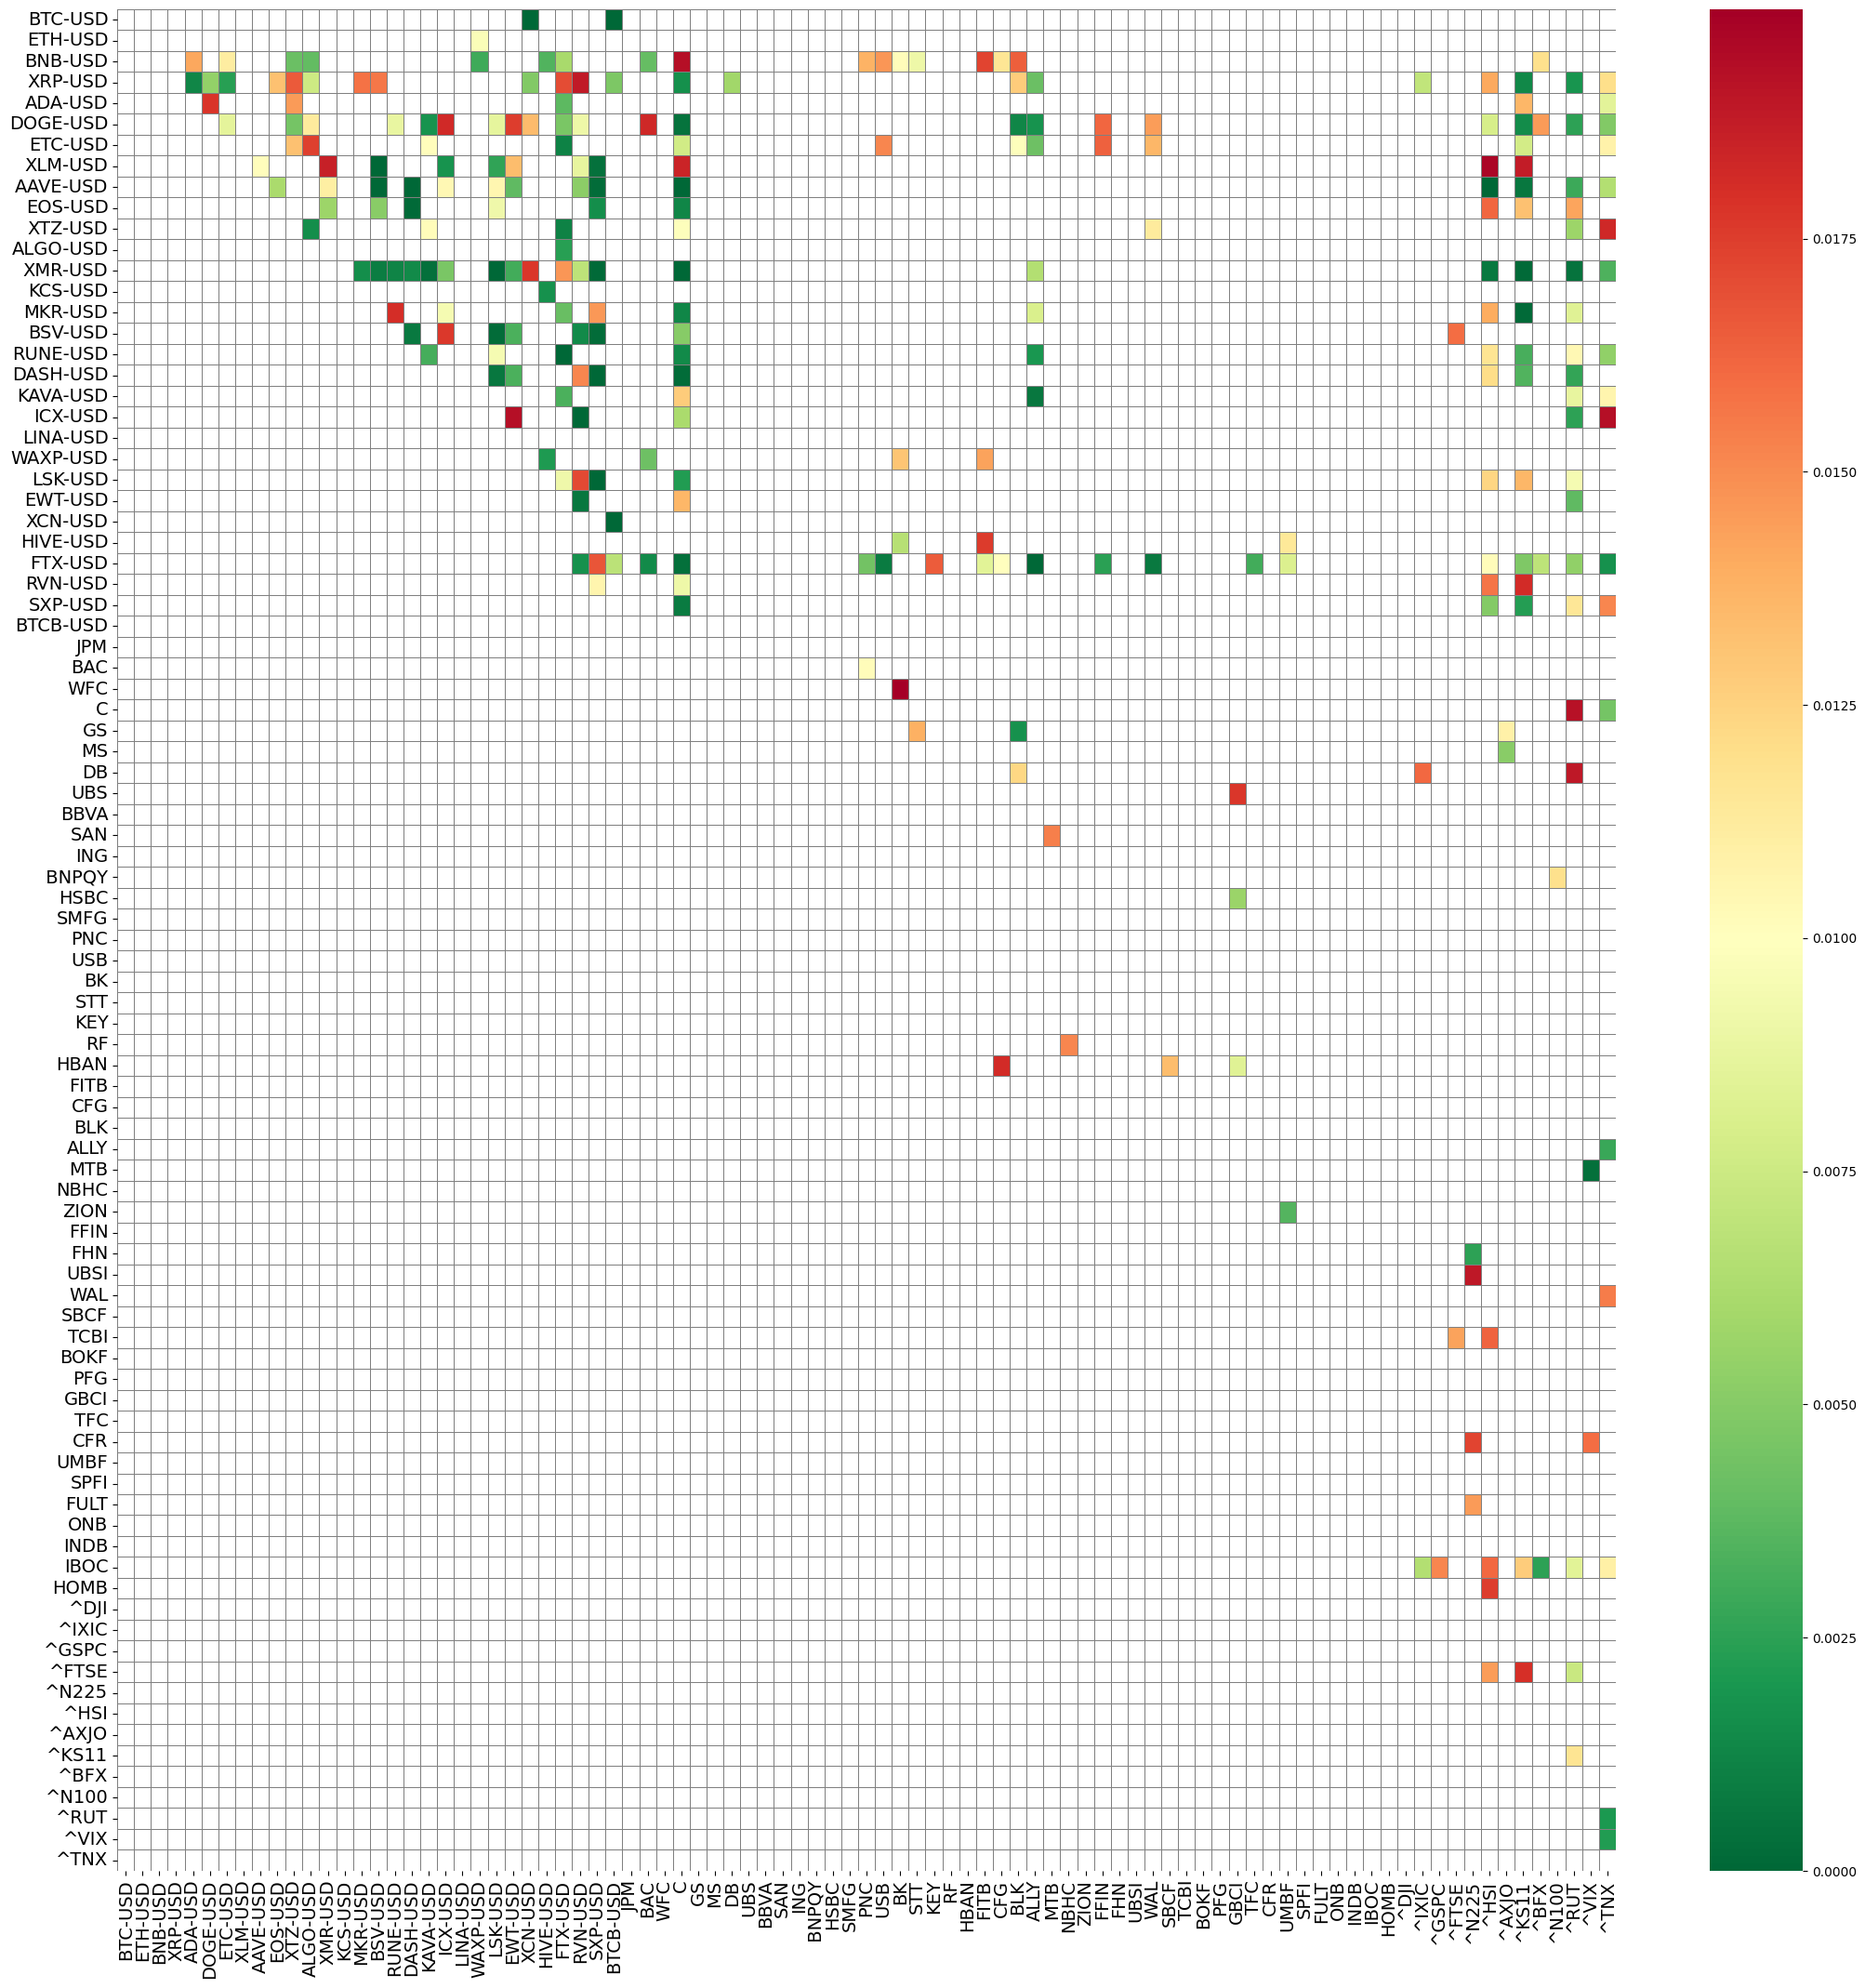

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_sanitized.keys(),
                      yticklabels=uts_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

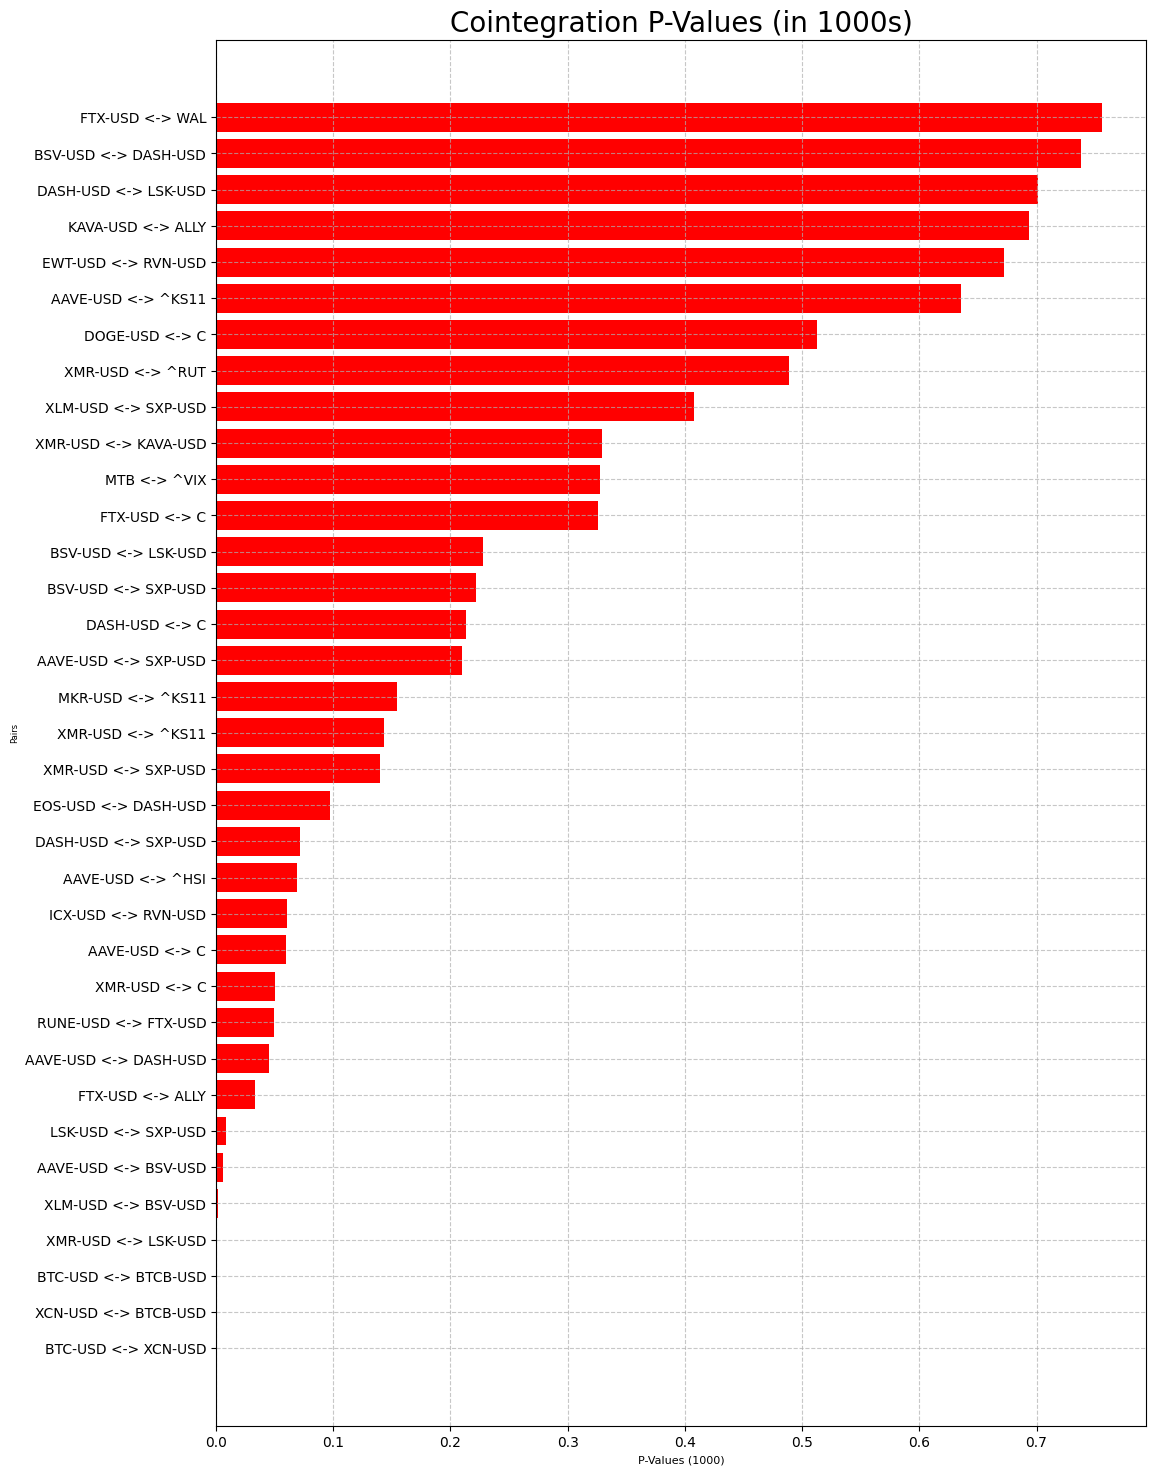

In [12]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs])
plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

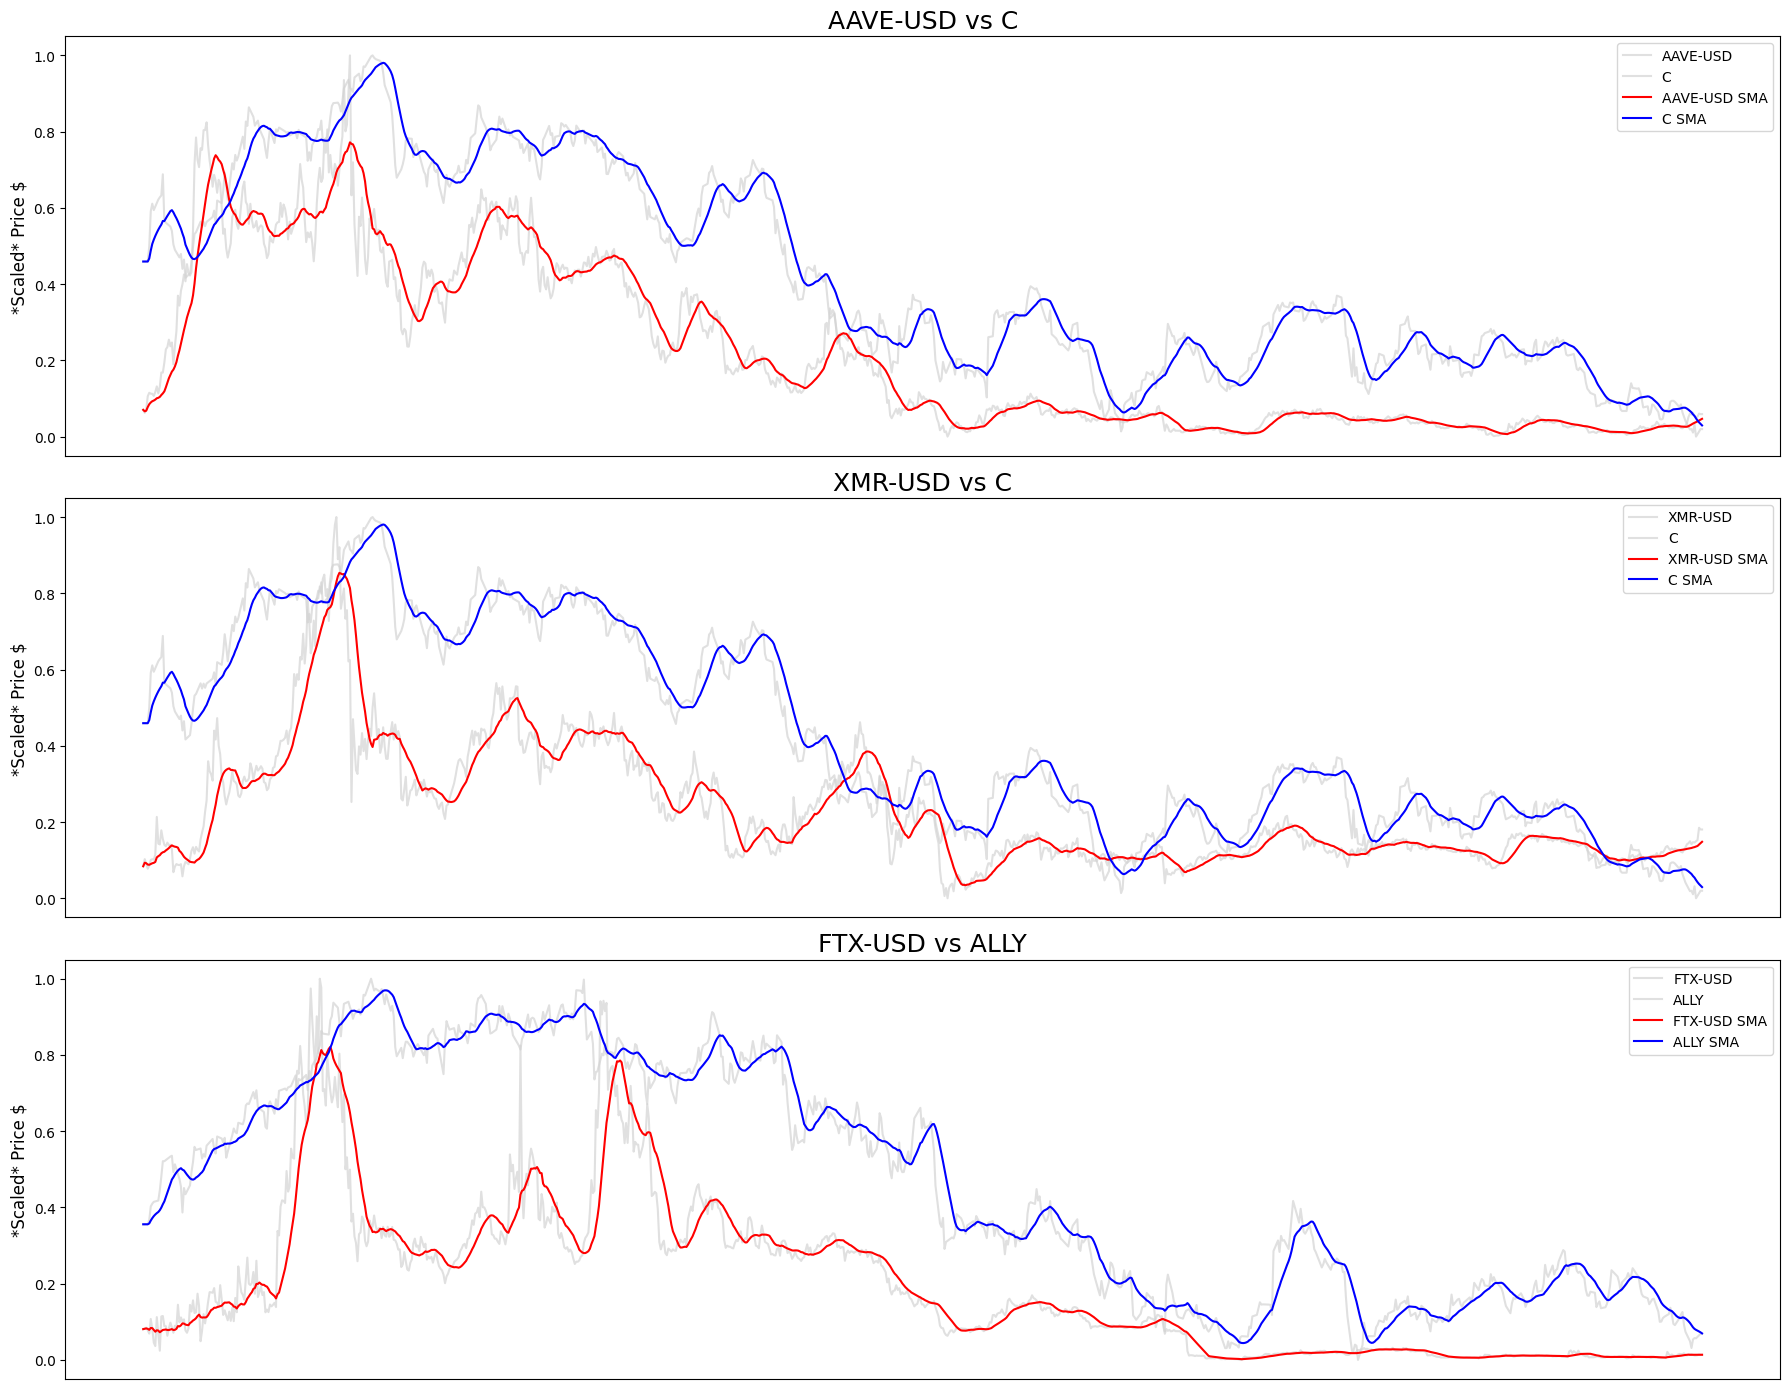

In [13]:
from sklearn.preprocessing import MinMaxScaler

ticker_pairs = [("AAVE-USD", "C"), ("XMR-USD", "C"), ("FTX-USD", "ALLY")]
fig, axs = plt.subplots(3, 1, figsize=(18, 14))
scaler = MinMaxScaler()
for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        uts_sanitized[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        uts_sanitized[ticker2]['Adj Close'].values.reshape(-1, 1))
    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)
    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()
    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')
    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])
plt.tight_layout()
plt.show()


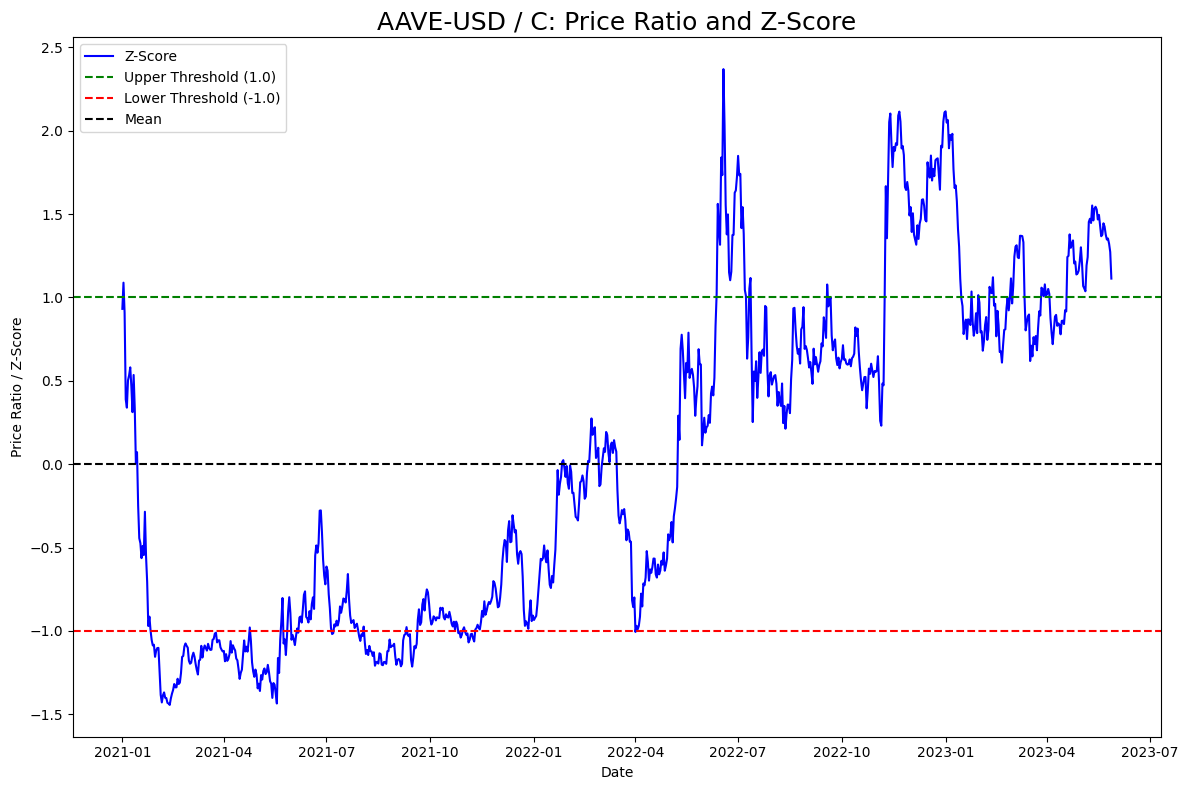

In [14]:
TRAIN = int(len(uts_sanitized["AAVE-USD"]) * 0.85)
TEST = len(uts_sanitized["AAVE-USD"]) - TRAIN

AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"][:TRAIN]
C_ts = uts_sanitized["C"]["Adj Close"][:TRAIN]
# Calculate price ratio (AAVE-USD price / C price)
ratios = C_ts/AAVE_ts
fig, ax = plt.subplots(figsize=(12, 8))
ratios_mean = np.mean(ratios)
ratios_std = np.std(ratios)
ratios_zscore = (ratios - ratios_mean) / ratios_std
ax.plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')
# Plot reference lines
ax.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
ax.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
ax.axhline(0, color="black", linestyle='--', label="Mean")
ax.set_title('AAVE-USD / C: Price Ratio and Z-Score', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Price Ratio / Z-Score')
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
def calculate_profit(signals_df, price_series):
    """
    Calculate the profit based on the trading signals and price series.

    Parameters:
    - signals_df (pandas.DataFrame): DataFrame containing the trading signals ('signal' and 'orders' columns).
    - price_series (pandas.Series): Time series of prices.

    Returns:
    - profit_df (pandas.DataFrame): DataFrame containing the profit for each trade.
    """
    # Create a DataFrame to store the profit for each trade
    profit_df = pd.DataFrame(index=price_series.index)
    profit_df['profit'] = 0.0

    # Iterate over the signals and calculate the profit
    for i in range(1, len(signals_df)):
        signal = signals_df['signal'].iloc[i]
        if signal != 0:
            if signal == 1:
                # Buy signal
                profit_df.loc[signals_df.index[i], 'profit'] = price_series.pct_change().iloc[i]
            else:
                # Sell signal
                profit_df.loc[signals_df.index[i], 'profit'] = -price_series.pct_change().iloc[i]

    # Calculate the cumulative profit
    profit_df['profit'] = profit_df['profit'].cumsum()

    return profit_df

In [30]:
def plot_strategy(price_series, signals_df, profit_df):
    """
    Plot the trading strategy and profit.

    Parameters:
    - price_series (pandas.Series): Time series of prices.
    - signals_df (pandas.DataFrame): DataFrame containing the trading signals ('signal' and 'orders' columns).
    - profit_df (pandas.DataFrame): DataFrame containing the profit for each trade.

    Returns:
    - ax1 (matplotlib.axes._subplots.AxesSubplot): Axis object for price and signal plot.
    - ax2 (matplotlib.axes._subplots.AxesSubplot): Axis object for profit plot.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot price and signals
    ax1.plot(price_series, label='Price')
    ax1.scatter(signals_df.loc[signals_df['signal'] == 1].index, price_series[signals_df['signal'] == 1], marker='^', color='g', label='Buy')
    ax1.scatter(signals_df.loc[signals_df['signal'] == -1].index, price_series[signals_df['signal'] == -1], marker='v', color='r', label='Sell')
    ax1.set_title('Trading Strategy')
    ax1.legend(loc='upper left')

    # Plot profit
    profit_df['profit'].plot(ax=ax2)
    ax2.set_title('Profit')

    plt.tight_layout()

    return ax1, ax2

In [31]:
# def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True):
#     """
#     Generate trading signals based on z-score analysis of the ratio between two time series.
#     Parameters:
#     - ticker1_ts (pandas.Series): Time series data for the first security.
#     - ticker2_ts (pandas.Series): Time series data for the second security.
#     - window_size (int): The window size for calculating z-scores and ratios' statistics.
#     - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.Returns:
#     - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
#     """
#     ratios = ticker1_ts / ticker2_ts
#     ratios_mean = ratios.rolling(
#         window=window_size, min_periods=1, center=False).mean()
#     ratios_std = ratios.rolling(
#         window=window_size, min_periods=1, center=False).std()
#     z_scores = (ratios - ratios_mean) / ratios_std
#     buy = ratios.copy()
#     sell = ratios.copy()
#     if first_ticker:
#         # These are empty zones, where there should be no signal
#         # the rest is signalled by the ratio.
#         buy[z_scores > -1] = 0
#         sell[z_scores < 1] = 0
#     else:
#         buy[z_scores < 1] = 0
#         sell[z_scores > -1] = 0
#     signals_df = pd.DataFrame(index=ticker1_ts.index)
#     signals_df['signal'] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
#     signals_df['orders'] = signals_df['signal'].diff()
#     signals_df.loc[signals_df['orders'] == 0, 'orders'] = None
#     return signals_df

In [33]:
def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True, threshold=1):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.

    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.
    - threshold (float): The z-score threshold for generating buy and sell signals.

    Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
    """
    ratios = ticker1_ts / ticker2_ts
    ratios_mean = ratios.rolling(window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(window=window_size, min_periods=1, center=False).std()
    z_scores = (ratios - ratios_mean) / ratios_std

    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = 0.0

    if first_ticker:
        signals_df.loc[z_scores > threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores < -threshold, 'signal'] = -1  # Sell signal
    else:
        signals_df.loc[z_scores < -threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores > threshold, 'signal'] = -1  # Sell signal

    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df

<Figure size 2600x1800 with 0 Axes>

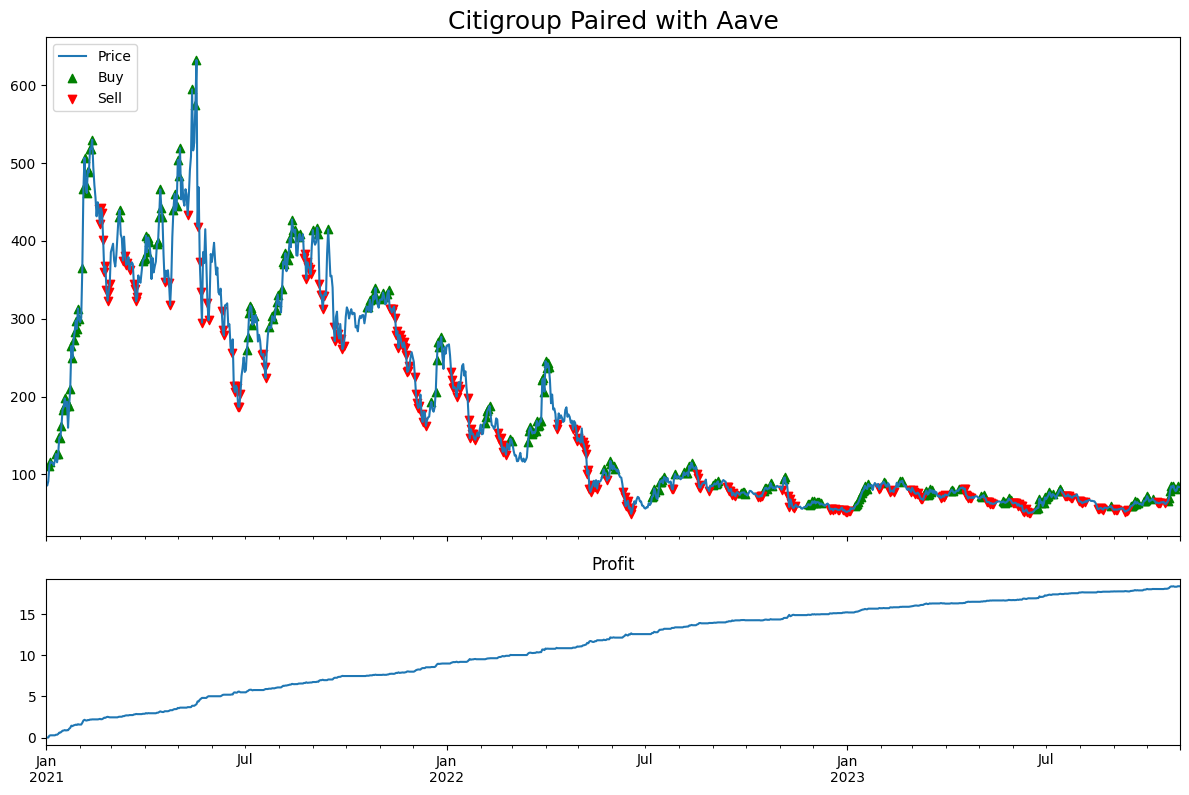

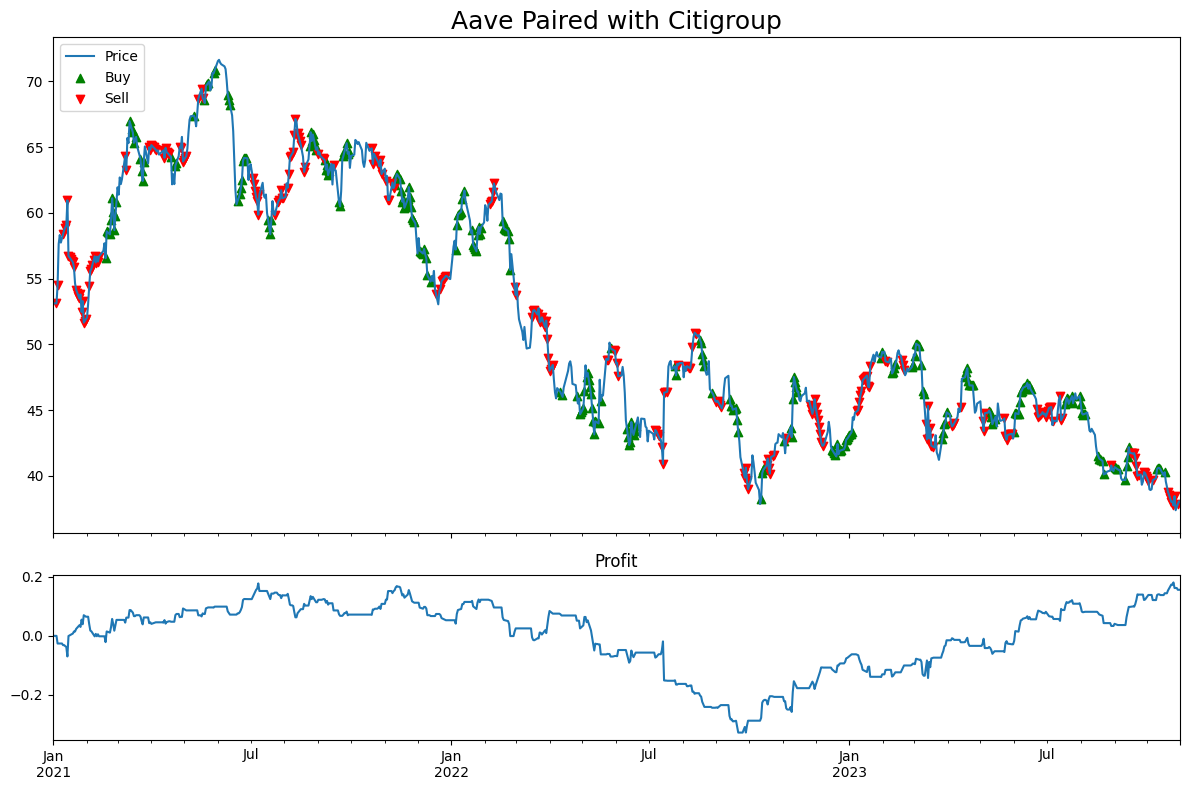

In [34]:
AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"]
C_ts = uts_sanitized["C"]["Adj Close"]

plt.figure(figsize=(26, 18))

signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts, threshold=1)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)

signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False, threshold=1)
profit_df2 = calculate_profit(signals_df2, C_ts)
ax2, _ = plot_strategy(C_ts, signals_df2, profit_df2)

ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f'Citigroup Paired with Aave', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f'Aave Paired with Citigroup', fontsize=18)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

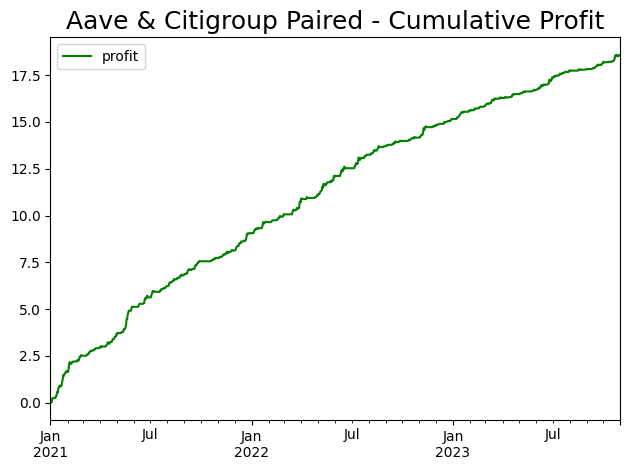

In [35]:
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'Aave & Citigroup Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()

<Figure size 2600x1800 with 0 Axes>

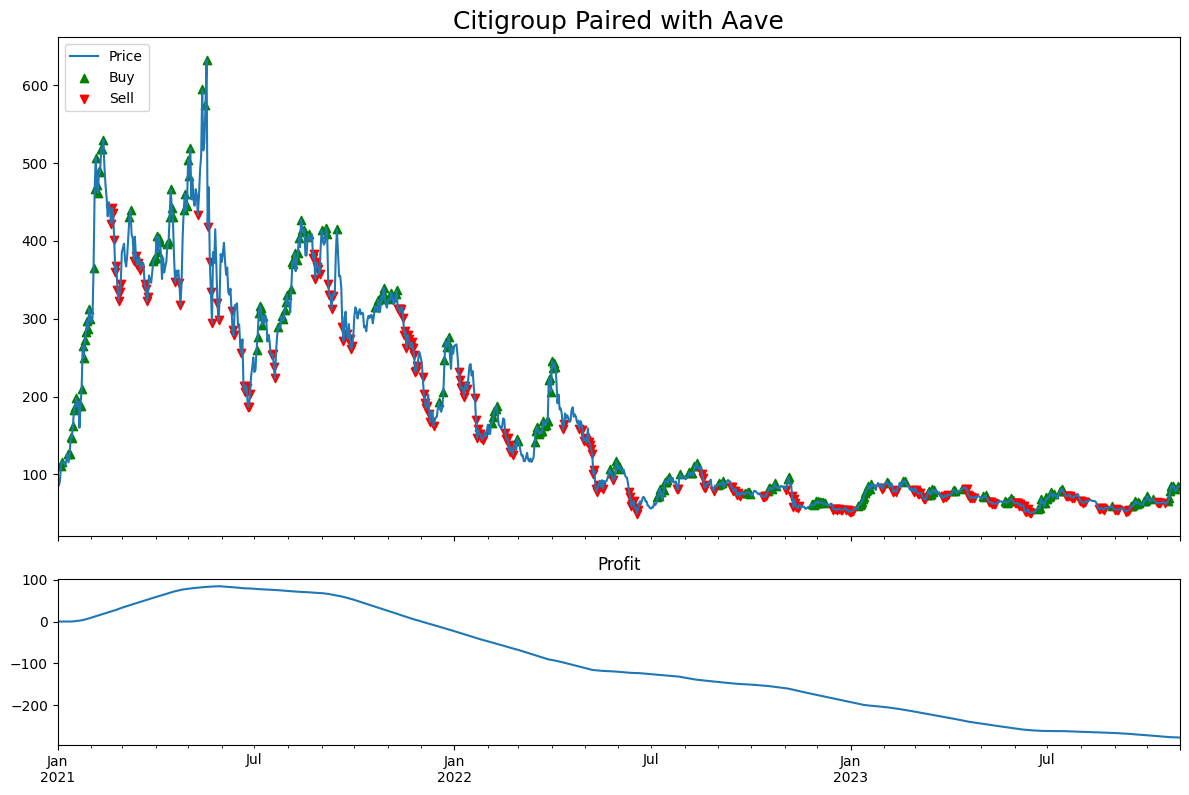

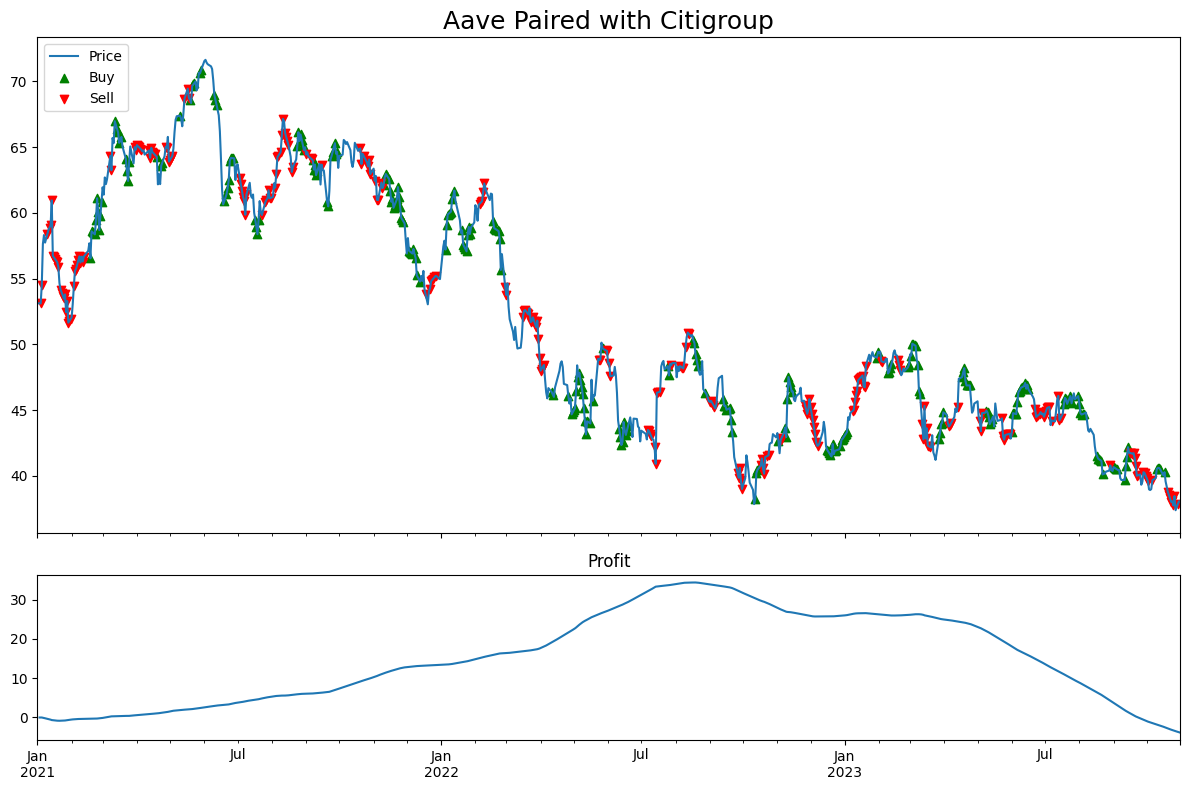

In [21]:
def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True, threshold=1):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.

    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.
    - threshold (float): The z-score threshold for generating buy and sell signals.

    Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
    """
    ratios = ticker1_ts / ticker2_ts
    ratios_mean = ratios.rolling(window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(window=window_size, min_periods=1, center=False).std()
    z_scores = (ratios - ratios_mean) / ratios_std

    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = 0.0

    if first_ticker:
        signals_df.loc[z_scores > threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores < -threshold, 'signal'] = -1  # Sell signal
    else:
        signals_df.loc[z_scores < -threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores > threshold, 'signal'] = -1  # Sell signal

    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df

AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"]
C_ts = uts_sanitized["C"]["Adj Close"]
plt.figure(figsize=(26, 18))
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)
signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, C_ts)
ax2, _ = plot_strategy(C_ts, signals_df2, profit_df2)
ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f'Citigroup Paired with Aave', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f'Aave Paired with Citigroup', fontsize=18)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

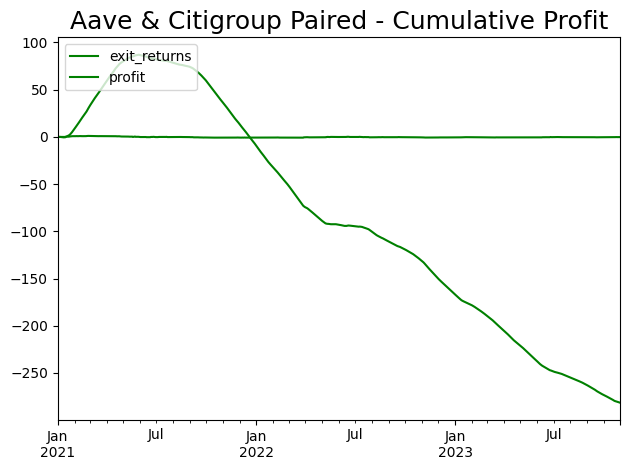

In [22]:
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'Aave & Citigroup Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
import requests

# Fetch BTC data from CoinGecko
btc_data = requests.get("https://api.coingecko.com/api/v3/coins/bitcoin/market_chart", params={"vs_currency": "usd", "days": 365}).json()
btc_prices = [d[1] for d in btc_data["prices"]]

# Fetch ETH data from CoinGecko
eth_data = requests.get("https://api.coingecko.com/api/v3/coins/ethereum/market_chart", params={"vs_currency": "usd", "days": 365}).json()
eth_prices = [d[1] for d in eth_data["prices"]]

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

# Define initial capital and risk percentage
initial_capital = 10000  # Example initial capital amount
risk_per_trade = 0.05  # Example risk per trade (5%)

# Fetch historical price data for Bitcoin and Ethereum
btc_prices = pd.Series(btc_prices)
eth_prices = pd.Series(eth_prices)

# Calculate the log returns
btc_returns = np.log(btc_prices / btc_prices.shift(1))
eth_returns = np.log(eth_prices / eth_prices.shift(1))

# Calculate the Z-scores
btc_zscore = (btc_returns - btc_returns.rolling(20).mean()) / btc_returns.rolling(20).std()
eth_zscore = (eth_returns - eth_returns.rolling(20).mean()) / eth_returns.rolling(20).std()

# Define the Z-score thresholds
zscore_threshold = 2

# Initialize the portfolio
portfolio = pd.DataFrame(columns=['BTC', 'ETH'], index=btc_prices.index[20:])

# Iterate over the price data
for i in tqdm(range(20, len(btc_prices)), desc='Running strategy'):
    date = btc_prices.index[i]

    # Calculate position size based on risk per trade
    position_size = initial_capital * risk_per_trade / btc_prices[i]

    # Check the Z-scores for BTC
    if btc_zscore[i] > zscore_threshold:
        btc_position = position_size  # Go long Bitcoin
        tqdm.write(f"{date}: Going long Bitcoin with {position_size} BTC at {btc_prices[i]}")
    elif btc_zscore[i] < -zscore_threshold:
        btc_position = -position_size  # Go short Bitcoin
        tqdm.write(f"{date}: Going short Bitcoin with {position_size} BTC at {btc_prices[i]}")
    else:
        btc_position = 0  # No position
        tqdm.write(f"{date}: No position in Bitcoin")

    # Check the Z-scores for ETH
    if eth_zscore[i] > zscore_threshold:
        eth_position = position_size  # Go long Ethereum
        tqdm.write(f"{date}: Going long Ethereum with {position_size} ETH at {eth_prices[i]}")
    elif eth_zscore[i] < -zscore_threshold:
        eth_position = -position_size  # Go short Ethereum
        tqdm.write(f"{date}: Going short Ethereum with {position_size} ETH at {eth_prices[i]}")
    else:
        eth_position = 0  # No position
        tqdm.write(f"{date}: No position in Ethereum")

    # Update the portfolio
    portfolio.loc[date, 'BTC'] = btc_position
    portfolio.loc[date, 'ETH'] = eth_position

# Calculate the portfolio returns
portfolio_returns = portfolio.sum(axis=1)  # No need to divide by 2

# Calculate the strategy performance
strategy_return = portfolio_returns.sum() / initial_capital  # Calculate as a percentage of initial capital
print(f"\nStrategy Return: {strategy_return * 100:.2f}%")

# Print a summary
print("\nStrategy Summary:")
print(f"Total Trades (Long + Short): {portfolio.abs().sum().sum()}")
print(f"Total Long Positions: {portfolio[portfolio > 0].sum().sum()}")
print(f"Total Short Positions: {portfolio[portfolio < 0].sum().sum()}")
print(f"Max Drawdown: {portfolio_returns.min() * 100:.2f}%")


Running strategy:   1%|          | 3/345 [00:00<00:13, 24.91it/s]

20: No position in Bitcoin
20: No position in Ethereum
21: No position in Bitcoin
21: Going long Ethereum with 0.01693748447067469 ETH at 1993.6129657474344
22: No position in Bitcoin
22: No position in Ethereum
23: No position in Bitcoin
23: No position in Ethereum
24: No position in Bitcoin
24: No position in Ethereum
25: No position in Bitcoin


Running strategy:   3%|▎         | 10/345 [00:00<00:11, 30.04it/s]

25: No position in Ethereum
26: No position in Bitcoin
26: No position in Ethereum
27: No position in Bitcoin
27: No position in Ethereum
28: No position in Bitcoin
28: No position in Ethereum
29: No position in Bitcoin
29: No position in Ethereum
30: No position in Bitcoin
30: No position in Ethereum
31: No position in Bitcoin
31: No position in Ethereum
32: No position in Bitcoin


Running strategy:   5%|▌         | 18/345 [00:00<00:11, 28.23it/s]

32: No position in Ethereum
33: No position in Bitcoin
33: No position in Ethereum
34: No position in Bitcoin
34: No position in Ethereum
35: No position in Bitcoin
35: No position in Ethereum
36: No position in Bitcoin
36: No position in Ethereum
37: No position in Bitcoin
37: No position in Ethereum


38: No position in Bitcoin
38: No position in Ethereum
39: No position in Bitcoin
39: No position in Ethereum
40: No position in Bitcoin
40: No position in Ethereum
41: No position in Bitcoin


Running strategy:   7%|▋         | 25/345 [00:01<00:12, 25.37it/s]

41: No position in Ethereum
42: No position in Bitcoin
42: No position in Ethereum
43: No position in Bitcoin
43: No position in Ethereum
44: Going long Bitcoin with 0.017787065966949667 BTC at 28110.313467609285
44: Going long Ethereum with 0.017787065966949667 ETH at 1913.8162493165785
45: No position in Bitcoin
45: No position in Ethereum
46: No position in Bitcoin
46: No position in Ethereum
47: No position in Bitcoin
47: No position in Ethereum
48: No position in Bitcoin


48: No position in Ethereum
49: No position in Bitcoin
49: No position in Ethereum


Running strategy:   8%|▊         | 29/345 [00:01<00:12, 26.32it/s]

50: No position in Bitcoin
50: No position in Ethereum


Running strategy:   9%|▉         | 32/345 [00:01<00:24, 12.84it/s]

51: No position in Bitcoin
51: No position in Ethereum
52: Going short Bitcoin with 0.019385393022979525 BTC at 25792.6160902334
52: Going short Ethereum with 0.019385393022979525 ETH at 1813.6816549003997


53: Going long Bitcoin with 0.018371130635674724 BTC at 27216.61556469773
53: No position in Ethereum
54: No position in Bitcoin
54: No position in Ethereum
55: No position in Bitcoin
55: No position in Ethereum
56: No position in Bitcoin
56: No position in Ethereum
57: No position in Bitcoin
57: No position in Ethereum
58: No position in Bitcoin


Running strategy:  12%|█▏        | 42/345 [00:02<00:15, 19.14it/s]

58: No position in Ethereum
59: No position in Bitcoin
59: No position in Ethereum
60: No position in Bitcoin
60: No position in Ethereum
61: No position in Bitcoin
61: No position in Ethereum
62: No position in Bitcoin
62: No position in Ethereum
63: No position in Bitcoin
63: No position in Ethereum
64: No position in Bitcoin


Running strategy:  15%|█▍        | 51/345 [00:02<00:11, 25.88it/s]

64: No position in Ethereum
65: No position in Bitcoin
65: No position in Ethereum
66: No position in Bitcoin
66: No position in Ethereum
67: Going long Bitcoin with 0.017648579869619832 BTC at 28330.891419807507
67: No position in Ethereum
68: No position in Bitcoin
68: No position in Ethereum
69: No position in Bitcoin
69: No position in Ethereum
70: No position in Bitcoin
70: No position in Ethereum
71: No position in Bitcoin
71: No position in Ethereum
72: No position in Bitcoin
72: No position in Ethereum
73: No position in Bitcoin
73: No position in Ethereum
74: No position in Bitcoin
74: No position in Ethereum
75: No position in Bitcoin


Running strategy:  20%|██        | 70/345 [00:02<00:05, 53.44it/s]

75: No position in Ethereum
76: No position in Bitcoin
76: No position in Ethereum
77: No position in Bitcoin
77: No position in Ethereum
78: No position in Bitcoin
78: No position in Ethereum
79: No position in Bitcoin
79: No position in Ethereum
80: No position in Bitcoin
80: No position in Ethereum
81: No position in Bitcoin
81: No position in Ethereum
82: No position in Bitcoin
82: No position in Ethereum
83: No position in Bitcoin
83: No position in Ethereum
84: No position in Bitcoin
84: No position in Ethereum
85: No position in Bitcoin
85: No position in Ethereum
86: No position in Bitcoin
86: No position in Ethereum
87: No position in Bitcoin
87: No position in Ethereum
88: No position in Bitcoin
88: No position in Ethereum
89: No position in Bitcoin
89: No position in Ethereum
90: Going long Bitcoin with 0.015900265914773917 BTC at 31446.0149710716
90: Going long Ethereum with 0.015900265914773917 ETH at 2003.253616074307
91: Going short Bitcoin with 0.016495211148761058 BTC 

Running strategy:  26%|██▋       | 91/345 [00:02<00:03, 64.54it/s]

97: No position in Bitcoin
97: No position in Ethereum
98: No position in Bitcoin
98: No position in Ethereum
99: No position in Bitcoin
99: No position in Ethereum
100: No position in Bitcoin
100: No position in Ethereum
101: No position in Bitcoin
101: No position in Ethereum
102: No position in Bitcoin
102: No position in Ethereum
103: No position in Bitcoin
103: No position in Ethereum
104: No position in Bitcoin
104: No position in Ethereum
105: No position in Bitcoin
105: No position in Ethereum
106: No position in Bitcoin
106: No position in Ethereum
107: No position in Bitcoin
107: No position in Ethereum
108: No position in Bitcoin
108: No position in Ethereum
109: No position in Bitcoin
109: No position in Ethereum
110: No position in Bitcoin
110: No position in Ethereum


Running strategy:  29%|██▊       | 99/345 [00:03<00:04, 55.86it/s]

111: No position in Bitcoin
111: No position in Ethereum
112: No position in Bitcoin
112: No position in Ethereum
113: No position in Bitcoin
113: No position in Ethereum
114: No position in Bitcoin
114: No position in Ethereum
115: No position in Bitcoin
115: No position in Ethereum
116: Going long Bitcoin with 0.016790038937433343 BTC at 29779.56167125089
116: No position in Ethereum
117: No position in Bitcoin
117: No position in Ethereum
118: No position in Bitcoin
118: No position in Ethereum
119: No position in Bitcoin
119: No position in Ethereum
120: No position in Bitcoin
120: No position in Ethereum
121: No position in Bitcoin


121: No position in Ethereum
122: No position in Bitcoin
122: No position in Ethereum
123: No position in Bitcoin
123: No position in Ethereum
124: No position in Bitcoin
124: No position in Ethereum
125: Going short Bitcoin with 0.018866794464326975 BTC at 26501.58726991974
125: Going short Ethereum with 0.018866794464326975 ETH at 1675.8621709457839
126: No position in Bitcoin
126: No position in Ethereum
127: No position in Bitcoin
127: No position in Ethereum
128: No position in Bitcoin
128: No position in Ethereum
129: No position in Bitcoin
129: No position in Ethereum
130: No position in Bitcoin
130: No position in Ethereum
131: No position in Bitcoin
131: No position in Ethereum
132: No position in Bitcoin
132: No position in Ethereum
133: No position in Bitcoin
133: No position in Ethereum
134: No position in Bitcoin
134: No position in Ethereum
135: No position in Bitcoin
135: No position in Ethereum
136: No position in Bitcoin
136: No position in Ethereum
137: Going long Bit

141: No position in Bitcoin
141: No position in Ethereum
142: No position in Bitcoin
142: No position in Ethereum
143: No position in Bitcoin
143: No position in Ethereum
144: No position in Bitcoin
144: No position in Ethereum
145: No position in Bitcoin
145: No position in Ethereum
146: No position in Bitcoin
146: No position in Ethereum
147: No position in Bitcoin
147: No position in Ethereum
148: No position in Bitcoin
148: No position in Ethereum
149: No position in Bitcoin
149: No position in Ethereum
150: No position in Bitcoin
150: Going short Ethereum with 0.019893923129800078 ETH at 1549.8934231592937
151: No position in Bitcoin
151: No position in Ethereum
152: No position in Bitcoin
152: No position in Ethereum
153: No position in Bitcoin
153: No position in Ethereum
154: No position in Bitcoin
154: No position in Ethereum
155: No position in Bitcoin
155: No position in Ethereum
156: No position in Bitcoin


Running strategy:  43%|████▎     | 149/345 [00:03<00:02, 71.49it/s]

156: No position in Ethereum
157: No position in Bitcoin
157: No position in Ethereum
158: No position in Bitcoin
158: No position in Ethereum
159: No position in Bitcoin
159: No position in Ethereum
160: No position in Bitcoin
160: No position in Ethereum
161: No position in Bitcoin
161: No position in Ethereum
162: No position in Bitcoin
162: No position in Ethereum
163: No position in Bitcoin
163: No position in Ethereum
164: No position in Bitcoin
164: No position in Ethereum
165: No position in Bitcoin
165: No position in Ethereum
166: No position in Bitcoin
166: No position in Ethereum
167: No position in Bitcoin
167: Going long Ethereum with 0.018512338311004812 ETH at 1652.196396535431
168: No position in Bitcoin
168: No position in Ethereum
169: No position in Bitcoin
169: No position in Ethereum
170: Going long Bitcoin with 0.01787788722153477 BTC at 27967.510579087113
170: Going long Ethereum with 0.01787788722153477 ETH at 1733.8180349156962
171: No position in Bitcoin
171:

172: No position in Bitcoin
172: No position in Ethereum
173: No position in Bitcoin
173: No position in Ethereum
174: No position in Bitcoin
174: No position in Ethereum
175: No position in Bitcoin
175: No position in Ethereum
176: No position in Bitcoin
176: No position in Ethereum
177: No position in Bitcoin
177: No position in Ethereum
178: No position in Bitcoin
178: No position in Ethereum
179: No position in Bitcoin
179: No position in Ethereum
180: No position in Bitcoin
180: No position in Ethereum
181: No position in Bitcoin
181: No position in Ethereum
182: No position in Bitcoin
182: No position in Ethereum
183: No position in Bitcoin
183: No position in Ethereum


184: No position in Bitcoin
184: No position in Ethereum
185: Going long Bitcoin with 0.017535670225030168 BTC at 28513.30993247735
185: No position in Ethereum
186: No position in Bitcoin
186: No position in Ethereum
187: No position in Bitcoin
187: No position in Ethereum
188: No position in Bitcoin
188: No position in Ethereum
189: No position in Bitcoin
189: No position in Ethereum
190: No position in Bitcoin
190: No position in Ethereum
191: No position in Bitcoin
191: No position in Ethereum
192: Going long Bitcoin with 0.015173004373767554 BTC at 32953.262760830985
192: Going long Ethereum with 0.015173004373767554 ETH at 1764.9303085804013
193: No position in Bitcoin
193: No position in Ethereum
194: No position in Bitcoin
194: No position in Ethereum
195: No position in Bitcoin
195: No position in Ethereum
196: No position in Bitcoin
196: No position in Ethereum
197: No position in Bitcoin
197: No position in Ethereum
198: No position in Bitcoin
198: No position in Ethereum


Running strategy:  56%|█████▌    | 193/345 [00:04<00:02, 67.23it/s]

199: No position in Bitcoin
199: No position in Ethereum
200: No position in Bitcoin
200: No position in Ethereum
201: No position in Bitcoin
201: No position in Ethereum
202: No position in Bitcoin
202: No position in Ethereum
203: No position in Bitcoin
203: No position in Ethereum
204: No position in Bitcoin
204: No position in Ethereum
205: No position in Bitcoin
205: No position in Ethereum
206: No position in Bitcoin
206: No position in Ethereum
207: No position in Bitcoin
207: No position in Ethereum
208: No position in Bitcoin
208: No position in Ethereum
209: No position in Bitcoin
209: Going long Ethereum with 0.013598625909435384 ETH at 2128.6095039438633
210: No position in Bitcoin
210: No position in Ethereum
211: No position in Bitcoin
211: No position in Ethereum
212: No position in Bitcoin
212: No position in Ethereum
213: No position in Bitcoin


Running strategy:  59%|█████▉    | 204/345 [00:04<00:01, 75.93it/s]

213: No position in Ethereum
214: Going short Bitcoin with 0.014066596329073413 BTC at 35545.201433454065
214: No position in Ethereum
215: Going long Bitcoin with 0.013191337397477895 BTC at 37903.66245166294
215: No position in Ethereum
216: Going short Bitcoin with 0.013811576246158922 BTC at 36201.51611146142
216: No position in Ethereum
217: No position in Bitcoin
217: No position in Ethereum
218: No position in Bitcoin
218: No position in Ethereum
219: No position in Bitcoin
219: No position in Ethereum
220: No position in Bitcoin
220: No position in Ethereum
221: No position in Bitcoin
221: No position in Ethereum
222: No position in Bitcoin
222: No position in Ethereum
223: No position in Bitcoin
223: No position in Ethereum
224: No position in Bitcoin
224: No position in Ethereum
225: No position in Bitcoin


Running strategy:  59%|█████▉    | 204/345 [00:04<00:01, 75.93it/s]

225: No position in Ethereum
226: No position in Bitcoin
226: No position in Ethereum


Running strategy:  62%|██████▏   | 213/345 [00:05<00:03, 42.54it/s]

227: No position in Bitcoin
227: No position in Ethereum
228: No position in Bitcoin
228: No position in Ethereum
229: No position in Bitcoin
229: No position in Ethereum
230: No position in Bitcoin
230: No position in Ethereum
231: No position in Bitcoin
231: No position in Ethereum
232: No position in Bitcoin
232: No position in Ethereum
233: No position in Bitcoin
233: No position in Ethereum
234: No position in Bitcoin
234: No position in Ethereum
235: No position in Bitcoin
235: No position in Ethereum
236: No position in Bitcoin
236: No position in Ethereum
237: No position in Bitcoin
237: No position in Ethereum
238: No position in Bitcoin
238: No position in Ethereum
239: No position in Bitcoin
239: No position in Ethereum
240: No position in Bitcoin
240: No position in Ethereum
241: Going short Bitcoin with 0.012135638754946845 BTC at 41200.96272610168
241: Going short Ethereum with 0.012135638754946845 ETH at 2222.3468384000316
242: No position in Bitcoin
242: No position in 

Running strategy:  65%|██████▌   | 225/345 [00:05<00:02, 53.84it/s]

244: No position in Ethereum
245: No position in Bitcoin
245: No position in Ethereum
246: No position in Bitcoin
246: No position in Ethereum
247: No position in Bitcoin
247: No position in Ethereum
248: No position in Bitcoin
248: No position in Ethereum
249: No position in Bitcoin
249: No position in Ethereum
250: No position in Bitcoin
250: No position in Ethereum
251: No position in Bitcoin
251: No position in Ethereum
252: No position in Bitcoin
252: No position in Ethereum
253: No position in Bitcoin


Running strategy:  68%|██████▊   | 234/345 [00:05<00:02, 50.05it/s]

253: No position in Ethereum
254: No position in Bitcoin
254: No position in Ethereum
255: No position in Bitcoin


255: No position in Ethereum
256: No position in Bitcoin
256: No position in Ethereum
257: No position in Bitcoin
257: Going long Ethereum with 0.01151583705326888 ETH at 2376.771249284193
258: No position in Bitcoin
258: No position in Ethereum
259: No position in Bitcoin
259: No position in Ethereum
260: No position in Bitcoin
260: No position in Ethereum
261: No position in Bitcoin
261: No position in Ethereum
262: Going long Bitcoin with 0.011320238380777852 BTC at 44168.68118687473
262: No position in Ethereum
263: No position in Bitcoin
263: No position in Ethereum
264: Going short Bitcoin with 0.011676361435757048 BTC at 42821.558989157995
264: Going short Ethereum with 0.011676361435757048 ETH at 2211.1708278638766
265: No position in Bitcoin
265: No position in Ethereum
266: No position in Bitcoin
266: No position in Ethereum
267: No position in Bitcoin
267: No position in Ethereum
268: No position in Bitcoin
268: No position in Ethereum
269: Going long Bitcoin with 0.01065276

Running strategy:  77%|███████▋  | 265/345 [00:06<00:01, 61.94it/s]

271: No position in Bitcoin
271: Going long Ethereum with 0.010722178812202252 ETH at 2588.769163919145
272: No position in Bitcoin
272: No position in Ethereum
273: Going short Bitcoin with 0.011656661084645234 BTC at 42893.92960550481
273: No position in Ethereum
274: No position in Bitcoin
274: No position in Ethereum
275: No position in Bitcoin
275: No position in Ethereum
276: No position in Bitcoin
276: No position in Ethereum
277: No position in Bitcoin
277: No position in Ethereum
278: No position in Bitcoin
278: No position in Ethereum
279: No position in Bitcoin
279: No position in Ethereum
280: No position in Bitcoin
280: No position in Ethereum
281: No position in Bitcoin
281: No position in Ethereum
282: No position in Bitcoin
282: No position in Ethereum
283: No position in Bitcoin
283: No position in Ethereum
284: No position in Bitcoin
284: No position in Ethereum
285: No position in Bitcoin
285: No position in Ethereum
286: No position in Bitcoin
286: No position in Et

295: No position in Ethereum
296: No position in Bitcoin
296: No position in Ethereum
297: No position in Bitcoin
297: No position in Ethereum
298: No position in Bitcoin
298: No position in Ethereum
299: No position in Bitcoin
299: No position in Ethereum
300: No position in Bitcoin
300: No position in Ethereum
301: No position in Bitcoin
301: No position in Ethereum
302: No position in Bitcoin
302: No position in Ethereum
303: No position in Bitcoin
303: No position in Ethereum
304: No position in Bitcoin
304: Going long Ethereum with 0.009989982825527339 ETH at 2657.990407976775
305: No position in Bitcoin
305: No position in Ethereum
306: No position in Bitcoin
306: No position in Ethereum
307: No position in Bitcoin
307: No position in Ethereum
308: No position in Bitcoin
308: No position in Ethereum
309: No position in Bitcoin
309: No position in Ethereum
310: No position in Bitcoin
310: No position in Ethereum
311: No position in Bitcoin
311: No position in Ethereum
312: No posi

Running strategy:  94%|█████████▍| 326/345 [00:06<00:00, 100.59it/s]

323: No position in Bitcoin
323: No position in Ethereum
324: No position in Bitcoin
324: No position in Ethereum
325: Going long Bitcoin with 0.0073328141184948155 BTC at 68186.64593432152
325: No position in Ethereum
326: Going short Bitcoin with 0.007777073418556077 BTC at 64291.536557569496
326: No position in Ethereum
327: No position in Bitcoin
327: Going long Ethereum with 0.007559045296426254 ETH at 3822.365818156151
328: No position in Bitcoin
328: No position in Ethereum
329: No position in Bitcoin
329: No position in Ethereum
330: No position in Bitcoin
330: No position in Ethereum
331: No position in Bitcoin
331: No position in Ethereum
332: No position in Bitcoin
332: No position in Ethereum
333: No position in Bitcoin
333: No position in Ethereum
334: No position in Bitcoin
334: No position in Ethereum
335: No position in Bitcoin
335: No position in Ethereum
336: No position in Bitcoin
336: No position in Ethereum
337: No position in Bitcoin
337: Going short Ethereum with

Running strategy: 100%|██████████| 345/345 [00:06<00:00, 51.69it/s] 


347: No position in Ethereum
348: No position in Bitcoin
348: No position in Ethereum
349: No position in Bitcoin
349: No position in Ethereum
350: No position in Bitcoin
350: No position in Ethereum
351: No position in Bitcoin
351: No position in Ethereum
352: No position in Bitcoin
352: No position in Ethereum
353: No position in Bitcoin
353: No position in Ethereum
354: No position in Bitcoin
354: No position in Ethereum
355: No position in Bitcoin
355: No position in Ethereum
356: No position in Bitcoin
356: No position in Ethereum
357: No position in Bitcoin
357: No position in Ethereum
358: No position in Bitcoin
358: No position in Ethereum
359: No position in Bitcoin
359: No position in Ethereum
360: No position in Bitcoin
360: No position in Ethereum
361: No position in Bitcoin
361: No position in Ethereum
362: No position in Bitcoin
362: No position in Ethereum
363: No position in Bitcoin
363: No position in Ethereum
364: No position in Bitcoin
364: Going short Ethereum with 

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import itertools

In [ ]:
# Function to scrape historical price data for multiple cryptocurrencies
def fetch_prices(crypto_name):
    # Simulated price data for demonstration
    # Replace this with your actual data fetching mechanism
    start_price = np.random.randint(1, 1000)
    prices = [start_price + np.random.uniform(-10, 10) for _ in range(100)]
    return pd.Series(prices, index=pd.date_range(start='2022-01-01', periods=100, freq='D'))

# List of cryptocurrencies
crypto_list = ['BTC', 'ETH', 'XRP', 'LTC', 'ADA', 'DOT', 'BNB', 'LINK', 'XLM', 'UNI',
               'DOGE', 'BCH', 'USDT', 'USDC', 'EOS', 'TRX', 'XTZ', 'VET', 'AAVE', 'SOL']

# Initialize a dictionary to store data for each cryptocurrency
crypto_data = {}

# Fetch historical price data and calculate metrics for each cryptocurrency
for crypto in tqdm(crypto_list, desc='Fetching data'):
    prices = fetch_prices(crypto)
    crypto_data[crypto] = {'prices': prices}

Fetching data: 100%|██████████| 20/20 [00:00<00:00, 600.00it/s]


In [ ]:
# Function to identify arbitrage opportunities
def find_arbitrage_opportunities(data):
    crypto_pairs = list(itertools.combinations(data.keys(), 2))  # Generate all possible pairs of cryptocurrencies

    best_opportunity = None
    best_profit = 0

    for pair in crypto_pairs:
        crypto1 = pair[0]
        crypto2 = pair[1]

        spread = data[crypto1]['prices'] - data[crypto2]['prices']

        arbitrage_potential = spread.mean()  # Example: Arbitrage potential is the average spread

        if arbitrage_potential > best_profit:
            best_profit = arbitrage_potential
            best_opportunity = pair

    return best_opportunity

In [ ]:
def execute_trades(trading_pair, initial_capital, risk_per_trade):
    if trading_pair:
        crypto1 = trading_pair[0]
        crypto2 = trading_pair[1]

        # Implement your trading logic here
        print(f"Executing trade: Buy {crypto1}, Sell {crypto2}")


In [ ]:
def main():
    # Find arbitrage opportunities
    trading_pair = find_arbitrage_opportunities(crypto_data)

    # Define initial capital and risk per trade
    initial_capital = 10000  # Example initial capital amount
    risk_per_trade = 0.02  # Example risk per trade (2%)

    # Execute trades
    execute_trades(trading_pair, initial_capital, risk_per_trade)


In [ ]:
# Run the main function
if __name__ == "__main__":
    main()

Executing trade: Buy BCH, Sell USDT


In [ ]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from datetime import datetime

# Function to fetch historical price data for a cryptocurrency (replace with actual data fetching mechanism)
def fetch_prices(crypto_name):
    start_price = np.random.randint(1, 1000)
    prices = [start_price + np.random.uniform(-10, 10) for _ in range(100)]
    return pd.Series(prices, index=pd.date_range(start='2022-01-01', periods=100, freq='D'))

# List of cryptocurrencies
crypto_list = ['BTC', 'ETH', 'XRP', 'LTC', 'ADA', 'DOT', 'BNB', 'LINK', 'XLM', 'UNI',
               'DOGE', 'BCH', 'USDT', 'USDC', 'EOS', 'TRX', 'XTZ', 'VET', 'AAVE', 'SOL']

# Function to fetch historical price data and initialize portfolio
def initialize_portfolio(crypto_list):
    portfolio = pd.DataFrame(columns=['Long', 'Short'], index=crypto_list)
    portfolio['Long'] = 0
    portfolio['Short'] = 0
    return portfolio

# Function to identify arbitrage opportunities
def find_arbitrage_opportunities(data):
    crypto_pairs = list(itertools.combinations(data.keys(), 2))
    best_opportunity = None
    best_profit = 0

    for pair in crypto_pairs:
        crypto1 = pair[0]
        crypto2 = pair[1]

        spread = data[crypto1]['prices'] - data[crypto2]['prices']
        arbitrage_potential = spread.mean()

        if arbitrage_potential > best_profit:
            best_profit = arbitrage_potential
            best_opportunity = pair

    return best_opportunity

# Function to execute trades
def execute_trades(trading_pair, portfolio, data):
    if trading_pair:
        crypto1 = trading_pair[0]
        crypto2 = trading_pair[1]
        spread = data[crypto1]['prices'] - data[crypto2]['prices']

        if spread.mean() > 0:  # Buy crypto1, sell crypto2
            portfolio.loc[crypto1, 'Long'] += 1
            portfolio.loc[crypto2, 'Short'] += 1
        else:  # Buy crypto2, sell crypto1
            portfolio.loc[crypto1, 'Short'] += 1
            portfolio.loc[crypto2, 'Long'] += 1

# Function to calculate portfolio metrics
def calculate_portfolio_metrics(portfolio):
    portfolio['Total'] = portfolio['Long'] + portfolio['Short']
    max_drawdown = portfolio['Total'].min()
    total_trades = portfolio['Total'].sum()
    return max_drawdown, total_trades

# Main function
def main():
    # Initialize portfolio
    portfolio = initialize_portfolio(crypto_list)

    # Fetch historical price data
    crypto_data = {}
    for crypto in crypto_list:
        crypto_data[crypto] = {'prices': fetch_prices(crypto)}

    # Trade for a certain number of iterations (e.g., 100)
    iterations = 20
    for _ in tqdm(range(iterations), desc='Running strategy'):
        # Find arbitrage opportunities
        trading_pair = find_arbitrage_opportunities(crypto_data)

        # Execute trades
        execute_trades(trading_pair, portfolio, crypto_data)

    # Calculate portfolio metrics
    max_drawdown, total_trades = calculate_portfolio_metrics(portfolio)

    # Print summary
    print("Portfolio Summary:")
    print(portfolio)
    print(f"Max Drawdown: {max_drawdown}")
    print(f"Total Trades: {total_trades}")

# Run the main function
if __name__ == "__main__":
    main()


Running strategy: 100%|██████████| 20/20 [00:01<00:00, 17.99it/s]

Portfolio Summary:
      Long  Short  Total
BTC     20      0     20
ETH      0      0      0
XRP      0      0      0
LTC      0      0      0
ADA      0      0      0
DOT      0     20     20
BNB      0      0      0
LINK     0      0      0
XLM      0      0      0
UNI      0      0      0
DOGE     0      0      0
BCH      0      0      0
USDT     0      0      0
USDC     0      0      0
EOS      0      0      0
TRX      0      0      0
XTZ      0      0      0
VET      0      0      0
AAVE     0      0      0
SOL      0      0      0
Max Drawdown: 0
Total Trades: 40


In [ ]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from datetime import datetime

# Function to fetch historical price data for a cryptocurrency (replace with actual data fetching mechanism)
def fetch_prices(crypto_name):
    start_price = np.random.randint(1, 1000)
    prices = [start_price + np.random.uniform(-10, 10) for _ in range(100)]
    return pd.Series(prices, index=pd.date_range(start='2022-01-01', periods=100, freq='D'))

# List of cryptocurrencies
crypto_list = ['BTC', 'ETH', 'XRP', 'LTC', 'ADA', 'DOT', 'BNB', 'LINK', 'XLM', 'UNI',
               'DOGE', 'BCH', 'USDT', 'USDC', 'EOS', 'TRX', 'XTZ', 'VET', 'AAVE', 'SOL']

# Function to fetch historical price data and initialize portfolio
def initialize_portfolio(crypto_list):
    portfolio = pd.DataFrame(columns=['Long', 'Short', 'Price'], index=crypto_list)
    portfolio['Long'] = 0
    portfolio['Short'] = 0
    portfolio['Price'] = 0
    return portfolio

# Function to identify arbitrage opportunities using z-score from highly correlated pairs
def find_arbitrage_opportunities(data):
    # Calculate correlation between price series of each cryptocurrency pair
    correlations = {}
    for pair in itertools.combinations(data.keys(), 2):
        crypto1 = pair[0]
        crypto2 = pair[1]
        correlations[pair] = data[crypto1]['prices'].corr(data[crypto2]['prices'])

    # Select pairs with high correlation coefficients (adjust threshold as needed)
    high_correlation_pairs = [pair for pair, corr in correlations.items() if corr > 0.6]  # Adjust threshold as needed

    # Use z-score from selected pairs to identify arbitrage opportunities
    arbitrage_pairs = []
    for pair in high_correlation_pairs:
        crypto1 = pair[0]
        crypto2 = pair[1]
        spread = data[crypto1]['prices'] - data[crypto2]['prices']
        z_score = (spread - spread.mean()) / spread.std()
        if z_score.mean() > 0:  # Buy crypto1, sell crypto2
            arbitrage_pairs.append(pair)
        else:  # Buy crypto2, sell crypto1
            arbitrage_pairs.append(pair[::-1])

    return arbitrage_pairs


# Function to execute trades
def execute_trades(trading_pairs, portfolio, data):
    for pair in trading_pairs:
        crypto1 = pair[0]
        crypto2 = pair[1]
        spread = data[crypto1]['prices'] - data[crypto2]['prices']

        if spread.mean() > 0:  # Buy crypto1, sell crypto2
            portfolio.loc[crypto1, 'Long'] += 1
            portfolio.loc[crypto2, 'Short'] += 1
            portfolio.loc[crypto1, 'Price'] = data[crypto1]['prices'].iloc[-1]
            portfolio.loc[crypto2, 'Price'] = data[crypto2]['prices'].iloc[-1]
        else:  # Buy crypto2, sell crypto1
            portfolio.loc[crypto1, 'Short'] += 1
            portfolio.loc[crypto2, 'Long'] += 1
            portfolio.loc[crypto1, 'Price'] = data[crypto1]['prices'].iloc[-1]
            portfolio.loc[crypto2, 'Price'] = data[crypto2]['prices'].iloc[-1]

# Function to calculate portfolio metrics
def calculate_portfolio_metrics(portfolio, initial_capital, risk_factor):
    total_trades = portfolio[['Long', 'Short']].sum().sum()
    max_drawdown = portfolio[['Long', 'Short']].min().min()
    total_profit_loss = (portfolio['Long'] * portfolio['Price']).sum() - (portfolio['Short'] * portfolio['Price']).sum()
    total_profit_loss -= initial_capital  # Subtract initial capital
    total_profit_loss -= (initial_capital * total_trades * risk_factor)  # Subtract risk factor
    return max_drawdown, total_trades, total_profit_loss

# Main function
def main():
    # Initialize portfolio
    portfolio = initialize_portfolio(crypto_list)

    # Fetch historical price data
    crypto_data = {}
    for crypto in crypto_list:
        crypto_data[crypto] = {'prices': fetch_prices(crypto)}

    # Trade for a certain number of iterations (e.g., 20)
    iterations = 20
    for _ in tqdm(range(iterations), desc='Running strategy'):
        # Find arbitrage opportunities
        trading_pairs = find_arbitrage_opportunities(crypto_data)

        # Execute trades
        execute_trades(trading_pairs, portfolio, crypto_data)

    # Define initial capital and risk factor
    initial_capital = 50000  # Initial capital amount
    risk_factor = 0.15  # Risk factor (5%)

    # Calculate portfolio metrics
    max_drawdown, total_trades, total_profit_loss = calculate_portfolio_metrics(portfolio, initial_capital, risk_factor)

    # Print summary
    print("Portfolio Summary:")
    print(portfolio)
    print(f"Max Drawdown: {max_drawdown}")
    print(f"Total Trades: {total_trades}")
    print(f"Total Profit/Loss: {total_profit_loss}")

# Run the main function
if __name__ == "__main__":
    main()

##price change
##both correlation

Running strategy: 100%|██████████| 20/20 [00:00<00:00, 26.92it/s]


Portfolio Summary:
      Long  Short  Price
BTC      0      0      0
ETH      0      0      0
XRP      0      0      0
LTC      0      0      0
ADA      0      0      0
DOT      0      0      0
BNB      0      0      0
LINK     0      0      0
XLM      0      0      0
UNI      0      0      0
DOGE     0      0      0
BCH      0      0      0
USDT     0      0      0
USDC     0      0      0
EOS      0      0      0
TRX      0      0      0
XTZ      0      0      0
VET      0      0      0
AAVE     0      0      0
SOL      0      0      0
Max Drawdown: 0
Total Trades: 0
Total Profit/Loss: -50000.0


In [ ]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from datetime import datetime, timedelta

# Function to fetch historical price data for a cryptocurrency (replace with actual data fetching mechanism)
def fetch_prices(crypto_name, start_date, end_date):
    start_price = np.random.randint(1, 1000)
    prices = [start_price + np.random.uniform(-10, 10) for _ in range((end_date - start_date).days * 24 + 1)]
    return pd.Series(prices, index=pd.date_range(start=start_date, end=end_date, freq='H'))

# List of cryptocurrencies
crypto_list = ['BTC', 'ETH', 'XRP', 'LTC', 'ADA', 'DOT', 'BNB', 'LINK', 'XLM', 'UNI',
               'DOGE', 'BCH', 'USDT', 'USDC', 'EOS', 'TRX', 'XTZ', 'VET', 'AAVE', 'SOL']

# Function to fetch historical price data and initialize portfolio
def initialize_portfolio(crypto_list):
    portfolio = pd.DataFrame(columns=['Long', 'Short', 'Price'], index=crypto_list)
    portfolio['Long'] = 0
    portfolio['Short'] = 0
    portfolio['Price'] = 0
    return portfolio

# Function to identify arbitrage opportunities using z-score from highly correlated pairs
def find_arbitrage_opportunities(data, window_size=24):
    # Calculate correlation between price series of each cryptocurrency pair
    correlations = {}
    for pair in itertools.combinations(data.keys(), 2):
        crypto1 = pair[0]
        crypto2 = pair[1]
        correlations[pair] = data[crypto1]['prices'].rolling(window=window_size).corr(data[crypto2]['prices'])

    # Select pairs with high correlation coefficients (adjust threshold as needed)
    high_correlation_pairs = [pair for pair, corr in correlations.items() if corr.mean() > 0.06]  # Adjust threshold as needed

    # Use z-score from selected pairs to identify arbitrage opportunities
    arbitrage_pairs = []
    for pair in high_correlation_pairs:
        crypto1 = pair[0]
        crypto2 = pair[1]
        spread = data[crypto1]['prices'] - data[crypto2]['prices']
        z_score = (spread - spread.rolling(window=window_size).mean()) / spread.rolling(window=window_size).std()
        if z_score.mean() > 0:  # Buy crypto1, sell crypto2
            arbitrage_pairs.append(pair)
        else:  # Buy crypto2, sell crypto1
            arbitrage_pairs.append(pair[::-1])

    return arbitrage_pairs

# Function to execute trades
def execute_trades(trading_pairs, portfolio, data):
    for pair in trading_pairs:
        crypto1 = pair[0]
        crypto2 = pair[1]
        spread = data[crypto1]['prices'] - data[crypto2]['prices']

        if spread.iloc[-1] > 0:  # Buy crypto1, sell crypto2
            portfolio.loc[crypto1, 'Long'] += 1
            portfolio.loc[crypto2, 'Short'] += 1
            portfolio.loc[crypto1, 'Price'] = data[crypto1]['prices'].iloc[-1]
            portfolio.loc[crypto2, 'Price'] = data[crypto2]['prices'].iloc[-1]
        else:  # Buy crypto2, sell crypto1
            portfolio.loc[crypto1, 'Short'] += 1
            portfolio.loc[crypto2, 'Long'] += 1
            portfolio.loc[crypto1, 'Price'] = data[crypto1]['prices'].iloc[-1]
            portfolio.loc[crypto2, 'Price'] = data[crypto2]['prices'].iloc[-1]

# Function to calculate portfolio metrics
def calculate_portfolio_metrics(portfolio, initial_capital, risk_factor):
    total_trades = portfolio[['Long', 'Short']].sum().sum()
    max_drawdown = portfolio[['Long', 'Short']].min().min()
    total_profit_loss = (portfolio['Long'] * portfolio['Price']).sum() - (portfolio['Short'] * portfolio['Price']).sum()
    total_profit_loss -= initial_capital  # Subtract initial capital
    total_profit_loss -= (initial_capital * total_trades * risk_factor)  # Subtract risk factor
    return max_drawdown, total_trades, total_profit_loss

# Main function
def main():
    # Initialize portfolio
    portfolio = initialize_portfolio(crypto_list)

    # Fetch historical price data
    start_date = datetime(2022, 1, 1)
    end_date = start_date + timedelta(days=7)
    crypto_data = {}
    for crypto in crypto_list:
        crypto_data[crypto] = {'prices': fetch_prices(crypto, start_date, end_date)}

    # Trade on an hourly basis
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    for date in tqdm(date_range, desc='Running strategy'):
        # Find arbitrage opportunities
        trading_pairs = find_arbitrage_opportunities(crypto_data, window_size=24)

        # Execute trades
        execute_trades(trading_pairs, portfolio, crypto_data)

    # Define initial capital and risk factor
    initial_capital = 1000  # Initial capital amount
    risk_factor = 0.05 # Risk factor (15%)

    # Calculate portfolio metrics
    max_drawdown, total_trades, total_profit_loss = calculate_portfolio_metrics(portfolio, initial_capital, risk_factor)

    # Print summary
    print("Portfolio Summary:")
    print(portfolio)
    print(f"Max Drawdown: {max_drawdown}")
    print(f"Total Trades: {total_trades}")
    print(f"Total Profit/Loss: {total_profit_loss}")

# Run the main function
if __name__ == "__main__":
    main()

Running strategy: 100%|██████████| 169/169 [00:39<00:00,  4.27it/s]

Portfolio Summary:
      Long  Short       Price
BTC    169    507  536.903729
ETH      0    507  177.056258
XRP    169    676  148.937387
LTC    507    169  242.126333
ADA    338    507  422.201485
DOT    507    169  749.913117
BNB      0   1183   87.080739
LINK  1183      0  912.672576
XLM    676    338  475.357887
UNI    169      0  680.206168
DOGE   169    507  252.933436
BCH    507      0  995.199248
USDT   676      0  762.947227
USDC     0    169  616.871771
EOS    169    169  681.268974
TRX      0   1183  169.121904
XTZ    845      0  844.097618
VET    169    338  597.836238
AAVE   169    169  723.749963
SOL    338    169  310.250802
Max Drawdown: 0
Total Trades: 13520
Total Profit/Loss: 1787670.8442694335


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

# Define initial capital and risk percentage
initial_capital = 10000  # Example initial capital amount
risk_per_trade = 0.02  # Example risk per trade (2%)

# Define the cryptocurrency pairs
pairs = {
    'BCH_BTC': {
        'btc_prices': btc_prices,
        'pair_prices': pd.Series(bch_btc_prices),
        'pair_name': 'Bitcoin Cash (BCH) / Bitcoin (BTC)'
    },
    'ETH_BTC': {
        'btc_prices': btc_prices,
        'pair_prices': pd.Series(eth_btc_prices),
        'pair_name': 'Ethereum (ETH) / Bitcoin (BTC)'
    },
    'ETH_XRP': {
        'btc_prices': eth_prices,  # Use ETH prices as base for Ripple pair
        'pair_prices': pd.Series(eth_xrp_prices),
        'pair_name': 'Ethereum (ETH) / Ripple (XRP)'
    }
}

# Calculate log returns for BTC
btc_returns = np.log(btc_prices / btc_prices.shift(1))

# Initialize results dictionary
results = {}

# Iterate over the cryptocurrency pairs
for pair_key, pair_data in pairs.items():
    pair_prices = pair_data['pair_prices']
    pair_name = pair_data['pair_name']

    # Calculate log returns for the pair
    pair_returns = np.log(pair_prices / pair_prices.shift(1))

    # Calculate the Z-scores
    pair_zscore = (pair_returns - pair_returns.rolling(20).mean()) / pair_returns.rolling(20).std()

    # Initialize the portfolio
    portfolio = pd.DataFrame(columns=['BTC', 'PAIR'], index=btc_prices.index[20:])

    # Iterate over the price data
    for i in tqdm(range(20, len(btc_prices)), desc=f'Running strategy for {pair_name}'):
        date = btc_prices.index[i]

        # Calculate position size based on risk per trade
        position_size = initial_capital * risk_per_trade / pair_prices[i]

        # Check the Z-scores
        if pair_zscore[i] > zscore_threshold:
            pair_position = position_size  # Go long the pair
            tqdm.write(f"{date}: Going long {pair_name} with {position_size} at {pair_prices[i]}")
        elif pair_zscore[i] < -zscore_threshold:
            pair_position = -position_size  # Go short the pair
            tqdm.write(f"{date}: Going short {pair_name} with {position_size} at {pair_prices[i]}")
        else:
            pair_position = 0  # No position
            tqdm.write(f"{date}: No position in {pair_name}")

        # Update the portfolio
        portfolio.loc[date, 'BTC'] = 0  # No BTC position
        portfolio.loc[date, 'PAIR'] = pair_position

    # Calculate the portfolio returns
    portfolio_returns = portfolio.sum(axis=1)  # No need to divide by 2

    # Calculate the strategy performance
    strategy_return = portfolio_returns.sum() / initial_capital  # Calculate as a percentage of initial capital
    results[pair_key] = {
        'strategy_return': strategy_return,
        'total_trades': portfolio.abs().sum().sum(),
        'total_long_positions': portfolio[portfolio > 0].sum().sum(),
        'total_short_positions': portfolio[portfolio < 0].sum().sum(),
        'max_drawdown': portfolio_returns.min() * 100
    }

    # Print a summary
    print(f"\nStrategy Summary for {pair_name}:")
    print(f"Strategy Return: {strategy_return * 100:.2f}%")
    print(f"Total Trades (Long + Short): {results[pair_key]['total_trades']}")
    print(f"Total Long Positions: {results[pair_key]['total_long_positions']}")
    print(f"Total Short Positions: {results[pair_key]['total_short_positions']}")
    print(f"Max Drawdown: {results[pair_key]['max_drawdown']:.2f}%")


NameError: name 'btc_prices' is not defined